# Self-Organising Maps

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines

from our_som1B import SOM

In [2]:
# reading data
data = pd.read_csv("cash-crops-nepal.csv")
# visualize some data
data.iloc[:10,:]

,Year AD,Year BS,Crop,Area,Production,Yield
0,1984/85,2041/42,OILSEED,127820,84030,657
1,1985/86,2042/43,OILSEED,137920,78390,568
2,1986/87,2043/44,OILSEED,142890,82500,577
3,1987/88,2044/45,OILSEED,151490,94370,623
4,1988/89,2045/46,OILSEED,154860,99190,641
5,1989/90,2046/47,OILSEED,153660,98060,638
6,1990/91,2047/48,OILSEED,156310,92140,589
7,1991/92,2048/49,OILSEED,154570,87840,568
8,1992/93,2049/50,OILSEED,165240,93690,567
9,1993/94,2050/51,OILSEED,177486,107535,606


In [3]:
data.shape

(105, 6)

In [4]:
# What are the different crops
print(data.iloc[:,2].unique())

['OILSEED' 'POTATO' 'TOBACCO' 'SUGARCANE' 'JUTE']


We will not use "Crop" labels for training SOM. But we will use it to check if the clustering by SOM worked fine or not. We will also drop the “Year AD” and “Year BS” columns.

In [5]:
# shuffling data
agri_data = data.iloc[np.random.permutation(len(data))]
trunc_data = agri_data[["Area", "Production", "Yield"]]
trunc_data.iloc[:10,:]

,Area,Production,Yield
84,27200,33124,1218
52,6028,5447,904
100,11289,16392,1452
51,6742,6223,923
53,6130,5510,899
65,24910,616580,24752
83,59082,2376103,40217
62,3003,3016,1004
86,19840,23452,1182
17,187820,134950,719


In [6]:
# (custom choice for) normalizing data
trunc_data = trunc_data / trunc_data.max()
trunc_data.iloc[:10,:]

,Area,Production,Yield
84,0.142835,0.013940,0.030286
52,0.031655,0.002292,0.022478
100,0.059282,0.006899,0.036104
51,0.035404,0.002619,0.022950
53,0.032190,0.002319,0.022354
65,0.130810,0.259492,0.615461
83,0.310257,1.000000,1.000000
62,0.015770,0.001269,0.024965
86,0.104186,0.009870,0.029391
17,0.986299,0.056795,0.017878


## Training SOM

Now let’s train the data in a 3 x 3 SOM network using 3 input features. 

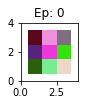

In [7]:
# som = SOM(x_size, y_size, num_features)
agri_som = SOM(3,3,3)

# Initial weights
init_fig = plt.figure()
agri_som.show_plot(init_fig, 1, 0)
plt.show()

Random weights (3 features) are given to each of 9 (3×3) neurons. The above figure shows how the neural network looks like in the beginning.

Notice: 

- after 60 Epochs, the network changed from random colors (initialization) to nearly constant color; this means that initial neighbourhood is large, so each neuron’s weight are being adjusted according to data.

- Slowly, the network develops different color according to input data structures/patterns, but, you can notice similar colors are neighbors to one another.

- Since there was a random initialization, the positions of colors may change but the topology will be preserved.

## Prediction and Analysis

In [8]:
def predict(df, agri_som):
    """
    finds the Best Matching Unit for each data sample.
    Thus, the neuron with closest distance from data sample.
    
    Args:
        df (pd.DataFrame): df to be updated
        agri_som (obj): model

    Returns:
        pd.DataFrame: updated df
    """
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df


In [9]:
def arrange_data(agri_som):
    """
    Fetch BMU of data samples and append them to the filtered agri_dataset    

    Args:
        agri_som (object): SOM model

    Returns:
        pd.DataFrame: updated agri_data with BMU
    """
    clustered_df = trunc_data.apply(predict, axis=1, agri_som=agri_som)
    joined_df = agri_data.join(clustered_df, rsuffix="_norm")
    return joined_df

In [10]:
def external_purity(df):
    """Purity measures the purity of clusters with respect to ground-truth class labels. To compute the purity of a clustering Q, 
    each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured 
    by counting the number of correctly assigned points and dividing by the total number of points:

    Args:
        df (pd.DataFrame): joined training set with bmu positions and weights
    """

    # proper representation of column
    df['bmu_idx'] = df['bmu_idx'].apply(lambda k: str(k))
    df['bmu'] = df['bmu'].apply(lambda k: k[0])

    # fetch number of different samples associated to each cluster.
    clusters = df.value_counts(subset=['Crop', 'bmu_idx']).reset_index() 
    clusters.rename(columns={0:'count'}, inplace=True)

    total = np.sum(clusters['count'])  # compute total number of points

    # assign class which is most frequent in the cluster. highest count of that specific crop type in cluster
    cluster_dominated = clusters.groupby(by=['Crop']).max().reset_index()
    total_correct = np.sum(cluster_dominated['count'])  # compute total number of correctly clustered
    
    return total_correct/total
    

In [11]:
def visualize(joined_df, agri_som, function):
    fig = plt.figure()
    # setup axes
    ax = fig.add_subplot(111)
    scale = 50
    ax.set_xlim((0, agri_som.net.shape[0]*scale))
    ax.set_ylim((0, agri_som.net.shape[1]*scale))
    ax.set_title("Neighborhood radius: "+function)

    for x in range(0, agri_som.net.shape[0]):
        for y in range(0, agri_som.net.shape[1]):
            ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                         facecolor='white',
                         edgecolor='grey'))
    legend_map = {}

    for index, row in joined_df.iterrows():
        x_cor = row['bmu_idx'][0] * scale
        y_cor = row['bmu_idx'][1] * scale
        x_cor = np.random.randint(x_cor, x_cor + scale)
        y_cor = np.random.randint(y_cor, y_cor + scale)
        color = row['bmu'][0]
        marker = "$\\ " + row['Crop'][0]+"$"
        marker = marker.lower()
        ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
        label = row['Crop']
        if not label in legend_map:
            legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                              markersize=10, label=label)
    plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
    plt.show()
    return joined_df

In [12]:
"""
executes SOM for epochs [5, 10, 20, 30, 40, 50]
"""

external_purities_5 = []
def run_5(weights, base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 10 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)

    agri_som.train(trunc_data.values,
          num_epochs=5,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_5.append(external_purity(joined_df))

external_purities_10 = []
def run_10(weights, base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 10 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)

    agri_som.train(trunc_data.values,
          num_epochs=10,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_10.append(external_purity(joined_df))

external_purities_20 = []
def run_20(weights, base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 20 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)

    agri_som.train(trunc_data.values,
          num_epochs=20,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_20.append(external_purity(joined_df))


external_purities_30 = []
def run_30(weights, base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 300 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)

    agri_som.train(trunc_data.values,
          num_epochs=30,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_30.append(external_purity(joined_df))

external_purities_40 = []
def run_40(weights, base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 40 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)

    agri_som.train(trunc_data.values,
          num_epochs=40,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_40.append(external_purity(joined_df))

external_purities_50 = []
def run_50(weights, base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 50 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)

    agri_som.train(trunc_data.values,
          num_epochs=50,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_50.append(external_purity(joined_df))


In [13]:
# More rates, and decay functions can be appended. cost is running time
lrs = [1, 0.1, 0.01, 0.001]  # base learning rates
lfs = ["default", "linear", "inverse", "power"]  # learning rate decay functions
rdfs = ["fixed", "linear", "exponential"]  # radius decay functions.

# 32 runs/combinations in all
mesh = np.array(np.meshgrid(lrs, lfs, rdfs))
lrs_lfs_rdfs = mesh.T.reshape(-1, 3)

# agri_som = SOM(3,3,3)  # initialization
# weights = agri_som.net
weights = np.array(
	[
		[
			[0.04039447, 0.6495641 , 0.46165352],
			[0.9118578 , 0.28238622, 0.39812322],
			[0.58684143, 0.11878689, 0.99220547]
		],
       [
			[0.46852085, 0.94825253, 0.61640755],
			[0.80456765, 0.03104591, 0.45691878],
			[0.29590234, 0.77207143, 0.81684638]
		],
       [
			[0.96509498, 0.26071734, 0.78689664],
			[0.12195003, 0.47102914, 0.92465288],
			[0.81227374, 0.46423983, 0.98292867]
		]
	]
)

print(len(lrs_lfs_rdfs), 'runs')

48 runs


In [14]:
agri_som = SOM(3,3,3)

In [15]:
agri_som.net

array([[[0.14232655, 0.89098258, 0.69732344],
        [0.62025906, 0.3225268 , 0.89803163],
        [0.90091294, 0.16944036, 0.51668597]],

       [[0.30410512, 0.53423031, 0.73314065],
        [0.70986595, 0.13907341, 0.69156456],
        [0.64601604, 0.29099648, 0.38828192]],

       [[0.21021339, 0.03654842, 0.81495324],
        [0.99001467, 0.46138403, 0.18593039],
        [0.5246808 , 0.50758245, 0.68807645]]])

In [16]:

for lr, lf, rdf in lrs_lfs_rdfs:
    lr = lr.astype('float64')
    run_5(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_10(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_20(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_30(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_40(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_50(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)

    print(f'lr:{lr}, lrf:{lf}, rdf:{rdf} done!')

lr:1.0, lrf:default, rdf:fixed done!
lr:1.0, lrf:linear, rdf:fixed done!
lr:1.0, lrf:inverse, rdf:fixed done!
lr:1.0, lrf:power, rdf:fixed done!
lr:0.1, lrf:default, rdf:fixed done!
lr:0.1, lrf:linear, rdf:fixed done!
lr:0.1, lrf:inverse, rdf:fixed done!
lr:0.1, lrf:power, rdf:fixed done!
lr:0.01, lrf:default, rdf:fixed done!
lr:0.01, lrf:linear, rdf:fixed done!
lr:0.01, lrf:inverse, rdf:fixed done!
lr:0.01, lrf:power, rdf:fixed done!
lr:0.001, lrf:default, rdf:fixed done!
lr:0.001, lrf:linear, rdf:fixed done!
lr:0.001, lrf:inverse, rdf:fixed done!
lr:0.001, lrf:power, rdf:fixed done!
lr:1.0, lrf:default, rdf:linear done!
lr:1.0, lrf:linear, rdf:linear done!
lr:1.0, lrf:inverse, rdf:linear done!
lr:1.0, lrf:power, rdf:linear done!
lr:0.1, lrf:default, rdf:linear done!
lr:0.1, lrf:linear, rdf:linear done!
lr:0.1, lrf:inverse, rdf:linear done!
lr:0.1, lrf:power, rdf:linear done!
lr:0.01, lrf:default, rdf:linear done!
lr:0.01, lrf:linear, rdf:linear done!
lr:0.01, lrf:inverse, rdf:linear 

### **Overall Performance**

In [17]:
# extract columns
lrs_ = [_[0] for _ in lrs_lfs_rdfs]
lfs_ = [_[1] for _ in lrs_lfs_rdfs]
rfs_ = [_[2] for _ in lrs_lfs_rdfs]

data = {
	'learning_function': lfs_,
	'radius_function': rfs_,
	'learning_rate': lrs_,
	'external_purities_5': external_purities_5, 
	'external_p10': external_purities_10, 
	'external_p20': external_purities_20,
	'external_p30': external_purities_30, 
	'external_p40': external_purities_40, 
	'external_p50': external_purities_50,
}
results_df = pd.DataFrame(
	data, index=range(1, len(lrs_)+1)
)

results_df.head()

,learning_function,radius_function,learning_rate,external_purities_5,external_p10,external_p20,external_p30,external_p40,external_p50
1,default,fixed,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,linear,fixed,1.0,0.885714,0.952381,0.914286,0.961905,0.923810,0.904762
3,inverse,fixed,1.0,0.780952,0.933333,0.952381,0.933333,0.923810,0.876190
4,power,fixed,1.0,0.885714,0.857143,0.952381,0.961905,0.980952,0.971429
5,default,fixed,0.1,0.895238,0.933333,0.866667,0.923810,0.971429,0.895238


In [18]:
# Descriptive statistics
results_df.describe()

,external_purities_5,external_p10,external_p20,external_p30,external_p40,external_p50
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.887698,0.891270,0.892262,0.897817,0.894048,0.891865
std,0.045227,0.036955,0.040366,0.041571,0.042936,0.039658
min,0.752381,0.819048,0.771429,0.780952,0.771429,0.819048
25%,0.866667,0.876190,0.873810,0.873810,0.866667,0.866667
50%,0.885714,0.885714,0.885714,0.890476,0.885714,0.885714
75%,0.916667,0.923810,0.923810,0.923810,0.923810,0.923810
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# Highest Accuracies
"""
Maximum Accuracy:
	- recorded for fixed radius for larger learning rates (1.0, 0.1, 0.01).
	- fixed radius performed well than the others.
"""
maxs = results_df.iloc[:,3:].idxmax().reset_index()
maxs.rename(columns={'index': 'column', 0: 'row'}, inplace=True)
max_rows = maxs['row'].values

# maximum rows for each epochs.
results_df[results_df.index.isin(max_rows)]

,learning_function,radius_function,learning_rate,external_purities_5,external_p10,external_p20,external_p30,external_p40,external_p50
1,default,fixed,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [20]:
# Minimum
"""
Minimum Accuracy:
	- linear radius decay function recorded minimum for 300 epochs at learning rate 1.0 
	- fixed radius also recorded this minimum at 400 epochs at a learning rate of 0.001
"""
mins = results_df.iloc[:,3:].idxmin().reset_index()
mins.rename(columns={'index': 'column', 0: 'row'}, inplace=True)
min_rows = mins['row'].values

# minimum rows for each epochs.
results_df[results_df.index.isin(min_rows)]

,learning_function,radius_function,learning_rate,external_purities_5,external_p10,external_p20,external_p30,external_p40,external_p50
34,linear,exponential,1.0,0.752381,0.847619,0.847619,0.857143,0.857143,0.828571
35,inverse,exponential,1.0,0.866667,0.819048,0.857143,0.866667,0.847619,0.847619
36,power,exponential,1.0,0.866667,0.914286,0.771429,0.847619,0.857143,0.876190
39,inverse,exponential,0.1,0.885714,0.866667,0.866667,0.866667,0.857143,0.819048
42,linear,exponential,0.01,0.885714,0.895238,0.895238,0.828571,0.771429,0.838095
43,inverse,exponential,0.01,0.847619,0.819048,0.790476,0.780952,0.866667,0.866667


### **Individual Performance**

In [21]:
# default
"""
fixed: 
	- overall accuracy increases with smaller learning rates.
	- accuracy increases for larger epochs

linear:
	- overall accuracy decreases with smaller learning rates.
	- for larger epochs, overall accuracy increases

exponential:
	- overall accuracy increases for  smaller learning rates for larger epochs
	- for larger epochs, accuracy marginally decreases
"""
results_df[results_df['learning_function'] == 'default']

,learning_function,radius_function,learning_rate,external_purities_5,external_p10,external_p20,external_p30,external_p40,external_p50
1,default,fixed,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,default,fixed,0.1,0.895238,0.933333,0.866667,0.923810,0.971429,0.895238
9,default,fixed,0.01,0.866667,0.952381,0.876190,0.952381,0.933333,0.933333
13,default,fixed,0.001,0.923810,0.923810,0.923810,0.923810,0.923810,0.923810
17,default,linear,1.0,1.000000,0.876190,1.000000,0.990476,0.971429,1.000000
21,default,linear,0.1,0.866667,0.923810,0.866667,0.933333,0.895238,0.923810
25,default,linear,0.01,0.885714,0.885714,0.885714,0.876190,0.876190,0.866667
29,default,linear,0.001,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714
33,default,exponential,1.0,0.952381,0.828571,0.885714,0.819048,0.857143,0.838095
37,default,exponential,0.1,0.857143,0.838095,0.866667,0.914286,0.857143,0.847619


In [22]:
# linear
"""
fixed: 
	- overall accuracy decreases for smaller learning rates.
	- accuracy remains fairly constant for larger learning rates but decrease for smaller learning rates.

linear:
	- overall accuracy decreases with smaller learning rates.
	- for larger epochs, accuracy decreases

exponential:
	- overall accuracy decreases for smaller learning rates, remains fairly constant for larger learning rates.
	- for increasing epochs,  accuracy remains constant for larger learning rates but decreases for smaller learning rates.
"""
results_df[results_df['learning_function'] == 'linear']

,learning_function,radius_function,learning_rate,external_purities_5,external_p10,external_p20,external_p30,external_p40,external_p50
2,linear,fixed,1.0,0.885714,0.952381,0.914286,0.961905,0.923810,0.904762
6,linear,fixed,0.1,0.914286,0.914286,0.923810,0.923810,0.923810,0.923810
10,linear,fixed,0.01,0.923810,0.923810,0.923810,0.923810,0.923810,0.923810
14,linear,fixed,0.001,0.923810,0.923810,0.923810,0.923810,0.923810,0.923810
18,linear,linear,1.0,0.866667,0.876190,0.876190,0.895238,0.885714,0.876190
22,linear,linear,0.1,0.876190,0.885714,0.885714,0.885714,0.885714,0.885714
26,linear,linear,0.01,0.866667,0.885714,0.885714,0.885714,0.885714,0.885714
30,linear,linear,0.001,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714
34,linear,exponential,1.0,0.752381,0.847619,0.847619,0.857143,0.857143,0.828571
38,linear,exponential,0.1,0.790476,0.819048,0.866667,0.866667,0.847619,0.857143


In [23]:
# inverse
"""
fixed: 
	- overall accuracy marginally increases for smaller learning rates.
	- accuracy increases steadily for larger learning rates, but performs poorly for very large epochs.
	- at 300 epochs, we recorded the best accuracy results.

linear:
	- overall accuracy increases with smaller learning rates.
	- for larger epochs, accuracy increases.

exponential:
	- overall accuracy increases for smaller learning rates, but performs very bad for very very smaller rate (0.001).
	- for increasing epochs, accuracy increases for larger learning rates but decreases for smaller learning rates.
"""

results_df[results_df['learning_function'] == 'inverse']

,learning_function,radius_function,learning_rate,external_purities_5,external_p10,external_p20,external_p30,external_p40,external_p50
3,inverse,fixed,1.0,0.780952,0.933333,0.952381,0.933333,0.923810,0.876190
7,inverse,fixed,0.1,0.876190,0.923810,0.923810,0.923810,0.923810,0.923810
11,inverse,fixed,0.01,0.923810,0.923810,0.923810,0.923810,0.923810,0.923810
15,inverse,fixed,0.001,0.923810,0.923810,0.923810,0.923810,0.923810,0.923810
19,inverse,linear,1.0,0.866667,0.876190,0.885714,0.866667,0.876190,0.885714
23,inverse,linear,0.1,0.876190,0.866667,0.876190,0.876190,0.885714,0.885714
27,inverse,linear,0.01,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714
31,inverse,linear,0.001,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714
35,inverse,exponential,1.0,0.866667,0.819048,0.857143,0.866667,0.847619,0.847619
39,inverse,exponential,0.1,0.885714,0.866667,0.866667,0.866667,0.857143,0.819048


In [24]:
# power
"""
fixed: 
	- overall accuracy decreases for smaller learning rates.
	- accuracy increases across epochs for large and very small learning rates.

linear:
	- overall accuracy decreases with smaller learning rates.
	- for larger epochs, accuracy increases for larger learning rates

exponential:
	- overall accuracy decreases for smaller learning rates.
	- for increasing epochs, accuracy for smaller learning rates decreases. 
"""
results_df[results_df['learning_function'] == 'power']

,learning_function,radius_function,learning_rate,external_purities_5,external_p10,external_p20,external_p30,external_p40,external_p50
4,power,fixed,1.0,0.885714,0.857143,0.952381,0.961905,0.980952,0.971429
8,power,fixed,0.1,0.971429,0.885714,0.885714,0.923810,0.933333,0.923810
12,power,fixed,0.01,0.923810,0.923810,0.923810,0.923810,0.923810,0.923810
16,power,fixed,0.001,0.923810,0.923810,0.923810,0.923810,0.923810,0.923810
20,power,linear,1.0,0.923810,0.895238,0.895238,0.914286,0.790476,0.847619
24,power,linear,0.1,0.866667,0.876190,0.895238,0.876190,0.885714,0.866667
28,power,linear,0.01,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714
32,power,linear,0.001,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714
36,power,exponential,1.0,0.866667,0.914286,0.771429,0.847619,0.857143,0.876190
40,power,exponential,0.1,0.866667,0.847619,0.857143,0.857143,0.857143,0.847619
